In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt

In [75]:
threshold = 80

# Load data

In [76]:
def load_stereo(dataset_dir='../data/stereo/train'):
    img_pairs = []

    for path in Path(dataset_dir + '/images').glob('*.png'):
        # check if not clear
        if path.name[-9:-6] != '000':
            image = np.array(Image.open(path).convert('L'))
            mask  = np.array(Image.open(dataset_dir + '/mask/' + path.name).convert('L'))
            img_pairs.append([image, mask])
    return img_pairs

In [77]:
stereo = load_stereo()[:100]

# Get patches

In [78]:
def get_patches(image, n, m):
    '''
        divide given 2d-nparray into n x m patches
        image - 2d-nparray (row, col)
        Returns: list of 2d-nparrays (patch, row, col)
    '''
    h, w = image.shape
    patch_h = (h + n-1) // n
    patch_w = (w + m-1) // m
    patches = []

    for i in np.arange(0, h, step=patch_h):
        for j in np.arange(0, w, step=patch_w):
            patches.append(image[i:i+patch_h, j:j+patch_w])
    return patches

In [79]:
def dataset_to_patched(dataset, form=(7, 13), threshold=0.5):
    features = []
    targets = []
    for [X, Y] in dataset:
        img_features = get_patches(X, form[0], form[1])
        img_targets = [(np.mean(x) >= threshold) for x in get_patches(Y, form[0], form[1])]
        features += img_features
        targets += img_targets
    return [features, targets]

In [80]:
patched = dataset_to_patched(stereo, threshold=threshold)

## Kurtosis measure

In [8]:
import scipy

In [9]:
def patched_kurtosis(image, form=(4,5)):
    patches = get_patches(image, form[0], form[1])
    one_dim_patches = [p.reshape(-1) for p in patches]
    return [scipy.stats.kurtosis(p) for p in one_dim_patches]

In [10]:
# Visualize patches with some measure
def visualize_patches(image, measure, n=4, m=5):
    patches = get_patches(image, n, m)
    fig, axs = plt.subplots(n, m, figsize=(18, 10))
    plt.gray()
    for i in range(len(patches)):
        axs[i // m, i % m].imshow(Image.fromarray(patches[i]))
        axs[i // m, i % m].axis('off')
        axs[i // m, i % m].set_title(str(measure(patches[i])))

In [11]:
def get_kurtosis(image):
    patched = np.asarray(patched_kurtosis(image, form=(2, 2)))
    return np.nansum(patched ** 2)

## DWT Shapness coeff

In [12]:
import pywt
import math

In [13]:
def subband_log_energy(subband, eps=1):
    coeffs = np.asarray(subband)
    return math.log10(eps + np.sum(coeffs ** 2)/len(coeffs))

In [14]:
def log_energy(dwt, alpha=0.7, eps=1):
    energy = [subband_log_energy(subband, eps) for subband in dwt]
    # energy[x] x: 0 - LL, 1 - LH, 2 - HL, 3 - HH
    return (1 - alpha) * (energy[1] + energy[2]) / 2 + alpha * energy[3]

In [15]:
def dwt_sharpcoeff(image, alpha=0.8):
    # Number of levels of dwt
    nlevels  = 6
    dwt = [image]

    # Energy for each level
    energy = []

    # Count log energy
    for p in range(nlevels):
        cA, (cH, cV, cD) = pywt.dwt2(dwt[0], 'haar')
        dwt = [cA, cH, cV, cD]
        energy.append(log_energy(dwt, alpha))

    # Count sharpness coeff
    coeff = np.nansum([2**(nlevels - p) * energy[p] for p in range(nlevels)])
    return coeff

In [16]:
def patched_dwt_sharpcoeff(image, form=(4, 5)):
    patches = get_patches(image, form[0], form[1])
    coeffs = [dwt_sharpcoeff(p) for p in patches]
    return coeffs

## SVD measure

In [17]:
def svd_coeff(image, d=5):
    '''
    Computes coefficient nu
    d - a number of first singular values used in nu
    '''
    U, S, VT = scipy.linalg.svd(image)
    if (np.nansum(S) == 0):
        return 0
    else:
        nu = np.nansum(S[:d]) / np.nansum(S)
    return nu

In [18]:
def patched_svd_coeff(image, d=1, form=(5, 8)):
    patches = get_patches(image, form[0], form[1])
    coeffs = [svd_coeff(p, d) for p in patches]

    return np.sum(np.array(coeffs) ** 2)

## Features

In [19]:
# Get features for all images
kurtosis = [get_kurtosis(img) for img in patched[0]]

C:\Users\KIR\AppData\Local\Temp\ipykernel_11628\3415617259.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return [scipy.stats.kurtosis(p) for p in one_dim_patches]


In [81]:
dwt = [dwt_sharpcoeff(img) for img in patched[0]]

In [82]:
svd = [patched_svd_coeff(img) for img in patched[0]]

## Prepare data

In [83]:
X = np.array([dwt, svd]).T
y = np.array(patched[1], dtype=int)

In [84]:
# Normalize X
X = (X - X.min(0)) / X.ptp(0)

In [85]:
part = int(len(X) * 0.9)
X_train, X_test, y_train, y_test = X[:part], X[part:], y[:part], y[part:]

In [86]:
# Show partition
head=5
print(X_train[:head])
print(y_train[:head])
print(X_test[:head])
print(y_test[:head])

[[0.40371855 0.85585359]
 [0.50824584 0.81184712]
 [0.56418307 0.82442514]
 [0.60815284 0.87889758]
 [0.3677344  0.88716255]]
[0 0 0 0 0]
[[0.24317183 0.87231235]
 [0.28647008 0.87760431]
 [0.36460615 0.90418874]
 [0.51778822 0.80649657]
 [0.36313042 0.89051958]]
[0 0 0 0 0]


In [87]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(
    n_estimators=110,
    criterion='gini',
    max_depth=30,
    random_state=50
)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Accuracy:", sum(1 - abs(y_pred - y_test)) / len(y_pred))

Accuracy: 0.8461538461538461


In [74]:
print(y_pred[3])

0


In [90]:
image = np.array(Image.open('../data/stereo/train/images/007_007_0.png').convert('L'))

In [96]:
mask = np.array(Image.open('../data/stereo/train/mask/007_007_0.png').convert('L'))

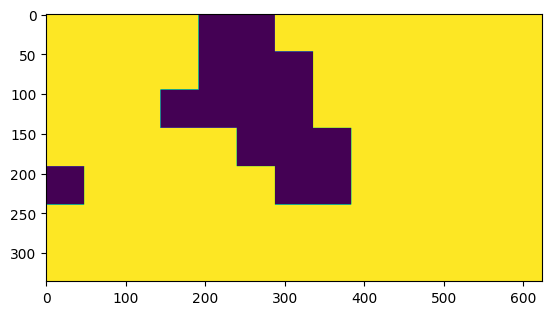

In [99]:
map = np.zeros(image.shape)
n = 7
m = 13
patches, mask_patches = get_patches(image, 7, 13), get_patches(mask, 7, 13)
for i in range(len(patches)):
    dwt = dwt_sharpcoeff(patches[i])
    svd = patched_svd_coeff(patches[i])
    y_pred = rfc.predict([[dwt, svd]])
    y_truth = int(np.mean(mask_patches[i]) >= 60)
    x_min = image.shape[0] // n * (i // m)
    y_min = image.shape[1] // m * (i % m)
    x_max = image.shape[0] // n * (i // m + 1)
    y_max = image.shape[1] // m * (i % m + 1)
    if (y_truth == 1):
        map[x_min:x_max, y_min:y_max].fill(255)
plt.imshow
plt.imshow(map)